# Exploration

In [2]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

from sklearn import manifold, decomposition, cluster
from sklearn.model_selection import train_test_split

import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [3]:
full_history = pd.read_json('data/history_comp.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))

full_history = full_history.drop('index', axis=1)

As shown below, for every 20 songs listened to, 10 of them are unique to my music catalog.

In [4]:
def get_unique():
    unique_history = full_history.drop('timestamp', axis=1)
    return unique_history.drop_duplicates('id')

len(full_history)/len(get_unique())

1.9713631156930127

Here is a sample of artists. In addition to the a priori known name, we have followers, genres, and popularity of each artist.

In [5]:
artists = pd.read_json('data/artist_info.json')
artists.sample(5)

,artist,followers,genres,id,popularity
2760,Holy White Hounds,4472,[],5GCvt7F9cCFkCjeEpcmFfL,32
1973,Sugar Minott,22554,"[dancehall, dub, lovers rock, reggae, reggae f...",6iTD167bhyfYwEd7fd2bGn,48
2430,John Lennon,1431470,"[album rock, art rock, classic rock, folk chri...",4x1nvY2FN8jxqAFA0DA02H,69
2482,Ohio Players,162092,"[chicago soul, classic funk rock, deep funk, d...",6m30rs1IQqnWqV5nKMpU7U,55
1956,happytree,1620,[trap soul],5UBfVxzuki4jF6yfZ8Omo2,40


### Visualizing Feature Space

Below we visualize the distributions of each feature. Pay close attention because we do make some modifications on a per-feature basis. These are designed to reduce error down the road.

In [6]:
def hist(X, xlim, bins=14):
    plt.xlim(xlim)
    N, bins, patches = plt.hist(X, bins=bins)

    fracs = N / N.max()

    norm = colors.Normalize(fracs.min(), fracs.max())

    for frac, patch in zip(fracs, patches):
        color = plt.cm.coolwarm(norm(frac))
        patch.set_facecolor(color)

### Acousticness

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

count    12047.000000
mean         0.300358
std          0.313313
min          0.000003
25%          0.038450
50%          0.176000
75%          0.503500
max          0.996000
Name: acousticness, dtype: float64

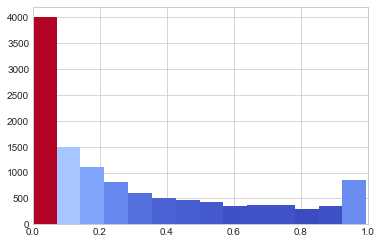

In [7]:
hist(full_history['acousticness'], [0,1])
full_history['acousticness'].describe()

### Danceability

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

count    12047.000000
mean         0.604429
std          0.169784
min          0.063400
25%          0.490000
50%          0.614000
75%          0.734000
max          0.984000
Name: danceability, dtype: float64

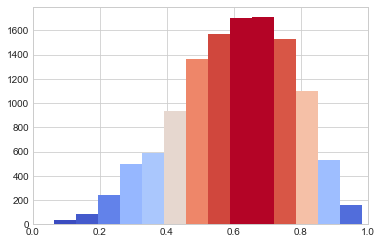

In [8]:
hist(full_history['danceability'], [0,1])
full_history['danceability'].describe()

### Duration

The duration of the track in milliseconds. Convert the duration to floating-point minutes.

count    12047.000000
mean         3.883627
std          1.395982
min          0.566450
25%          3.162992
50%          3.669283
75%          4.351750
max         41.074900
Name: duration, dtype: float64

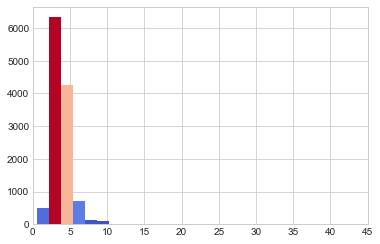

In [9]:
full_history['duration'] = full_history['duration_ms'] / 1000 / 60
hist(full_history['duration'], [0,45], 25)
full_history['duration'].describe()

In [10]:
full_history = full_history.drop('duration_ms', axis=1)

### Energy

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

count    12047.000000
mean         0.579678
std          0.228323
min          0.000803
25%          0.443000
50%          0.599000
75%          0.748000
max          0.998000
Name: energy, dtype: float64

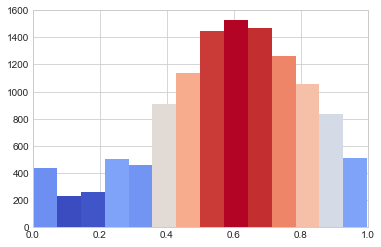

In [11]:
hist(full_history['energy'], [0,1])
full_history['energy'].describe()

### Liveness

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

count    12047.000000
mean         0.188938
std          0.153650
min          0.018700
25%          0.097600
50%          0.123000
75%          0.231000
max          0.989000
Name: liveness, dtype: float64

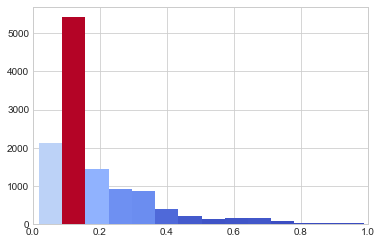

In [12]:
hist(full_history['liveness'], [0,1])
full_history['liveness'].describe()

In [13]:
full_history[full_history['liveness'] > 0.8].drop_duplicates('id')['name'][:15]

10036                                        Encore
1016                                 Round Whippin'
10303                                       Feel Me
10308                                          TEAM
10365                Namaste, Alvida - Original Mix
10679                             I’m On Everything
10978                                    So Special
11240                             That's How - Skit
1204                                 Starting Today
1229                         Get Up Offa That Thing
1388       Jah No Partial - Heroes x Villains Remix
16                                         My Girls
1916                       Fell In Love With A Girl
1917     Not Nineteen Forever - Live at Heaton Park
2146                                       Soldiers
Name: name, dtype: object

Liveness is obviously an inaccurate measurement, thus we cannot use it reliably. We remove it.

In [14]:
full_history = full_history.drop('liveness', axis=1)

### Loudness

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

Similar to duration, loudness is heavily skewed, thus we log scale it to bring things back together and reveal more of the underlying structure. Note the transformation of the values too. Since we don't care too much about the actual value of the loudness, only whether it's relatively loud or not, we assume this is acceptable.

count    12047.000000
mean         2.150195
std          0.459787
min         -0.529329
25%          1.864235
50%          2.114688
75%          2.366967
max          3.877990
Name: log_loudness, dtype: float64

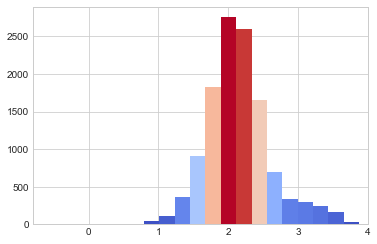

In [15]:
full_history['log_loudness'] = np.log(-1*full_history['loudness']+1)
hist(full_history['log_loudness'], [-0.8,4], 20)
full_history['log_loudness'].describe()

In [16]:
full_history = full_history.drop('loudness', axis=1)

### Popularity

The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

count    12047.000000
mean        54.093218
std         17.425109
min          0.000000
25%         44.000000
50%         56.000000
75%         65.000000
max        100.000000
Name: popularity, dtype: float64

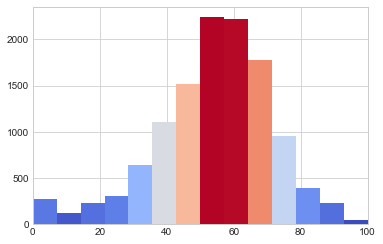

In [17]:
hist(full_history['popularity'], [0, 100])
full_history['popularity'].describe()

### Tempo

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

count    12047.000000
mean       117.998672
std         30.037381
min         32.000000
25%         94.000000
50%        118.000000
75%        140.000000
max        222.000000
Name: tempo, dtype: float64

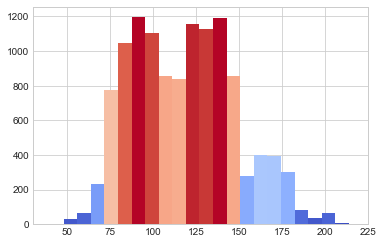

In [18]:
full_history['tempo'] = full_history['tempo'].apply(round)
hist(full_history['tempo'], [30, 225], 24)
full_history['tempo'].describe()

Many songs are misclassified by Spotify, often doubling the real BPM. Presto tempo is said to be above 168, and after looking through many of the resutls of songs above 168 BPM, it is reasonable to correct songs above this threshold. Although it does cut out the top end, it is more representative for  many songs.

In [19]:
full_history['tempo'] = full_history['tempo'].apply(lambda x: x if x < 168 else x/2)

### Valence

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

count    12047.000000
mean         0.434586
std          0.238469
min          0.024600
25%          0.239000
50%          0.412000
75%          0.613000
max          0.990000
Name: valence, dtype: float64

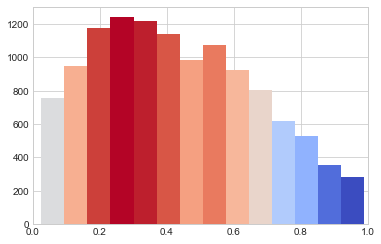

In [20]:
hist(full_history['valence'], [0, 1])
full_history['valence'].describe()

### Release Date

After examining, the release date isn't accurate either. For example, all classical music has release dates of 1960 or later, since this is the release of the album itself, not necessarily the conception of the music (which would have placed a lot of this genre in the 17th-20th centuries).

In [21]:
full_history = full_history.drop('release', axis=1)

How much music are we talking about here?

In [22]:
total_hours = full_history['duration'].sum()/(60)
print('Total hours: {:0.3f}'.format(total_hours))

hours_per_day = total_hours/(full_history['timestamp'].max() - full_history['timestamp'].min()).days
print('Hours/day: {:0.1f}'.format(hours_per_day))

avg_song_dur = full_history['duration'].mean()
print('Average songs/day: {:0.0f}'.format(hours_per_day/(avg_song_dur/(60.0))))

print('Total songs listened to: {} (unique songs: {})'.format(len(full_history), len(get_unique())))

Total hours: 779.768
Hours/day: 5.2
Average songs/day: 80
Total songs listened to: 12047 (unique songs: 6111)


In [23]:
full_history.sample(5)

,acousticness,album,artists,danceability,energy,explicit,id,key,mode,name,popularity,speechiness,tempo,time_signature,timestamp,valence,duration,log_loudness
2644,0.995,Shostakovich: 24 Preludes & Fugues,"[6s1pCNXcbdtQJlsnM1hRIA, 7vk7vgVoYDiZ4Kngc3Jgta]",0.401,0.0276,0,14dUx4xRdtdMwSGkEmv3Bg,3,1,"24 Preludes & Fugues, Op. 87: Prelude no.19 in...",2,0.0705,135.0,4,2018-03-16 16:54:00-07:00,0.101,1.846883,3.373346
6807,0.169,Steps,[3IaqL9bsZtYJkqNLiovVho],0.580,0.5570,0,3YW7AWZMCvNBYBPoFdebTh,1,1,Weight Of It All,46,0.0745,166.0,4,2017-12-21 22:11:00-08:00,0.407,3.428450,2.292737
7912,0.158,War & Leisure,"[360IAlyVv4PCEVjgyMZrxK, 6l3HvQ5sa6mXTsMTB19rO...",0.461,0.6530,1,1m8WpLYXEiNVZchsWEcCSy,6,1,Come Through and Chill,76,0.3270,82.0,1,2018-01-19 07:54:00-08:00,0.588,5.366667,2.263532
1602,0.868,Crazy in Love,[0WfaItAbs4vlgIA1cuqGtJ],0.606,0.3260,0,6m0qBDIhzICOwWMPZdgyVK,7,1,Crazy in Love,65,0.1190,79.0,4,2018-03-28 21:21:00-07:00,0.489,3.791667,2.341902
3307,0.599,Chase Atlantic,[7cYEt1pqMgXJdq00hAwVpT],0.372,0.5710,1,0VCaMojESxrxingY2tNS4Q,4,1,23,51,0.0931,136.0,3,2018-03-09 10:04:00-08:00,0.313,4.630667,2.232377


## What kinds of music do I listen to?

First, what types of genres am I listening to?

In [24]:
artists_index = pd.Index(artists['id'])

def addTrackGenres(row):
    inner_gs = []
        
    # for each artist in a track
    for track_artist in row['artists']:
                        
        # if the artist exists, get its index
        i = artists_index.get_loc(track_artist)
        if i > -1:
            cell = artists.iloc[i, 2]
            if cell:
                # collect genres from artists that match the current index
                inner_gs.append(cell)
                
    if inner_gs:
        row['genres'] = np.unique(list(itertools.chain(*inner_gs)))
    else:
        row['genres'] = None
        
    return row


In [25]:
full_history = full_history.apply(addTrackGenres, 1)

In [26]:
genres = []
counts = []
freqs =  []
var1 =   []

for row in full_history.loc[full_history['genres'].notnull(), ['energy', 'genres']].itertuples():
    
    for genre in row.genres:
        
        if genre in genres:
            i = genres.index(genre)
            counts[i] += 1
            var1[i] += row.energy
        else:
            genres.append(genre)
            counts.append(1)
            var1.append(row.energy)

total = sum(counts)
freqs = np.array(counts) / total
var1 = np.array(var1) / np.array(counts)

collective_genres = pd.DataFrame({'freq': freqs, 'count': counts, 'genre': genres, 'var1': var1})

Below is a visualization of my top 25 genres, starting with most listened to. Dark blue represents a low energy, dark red is high energy.

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


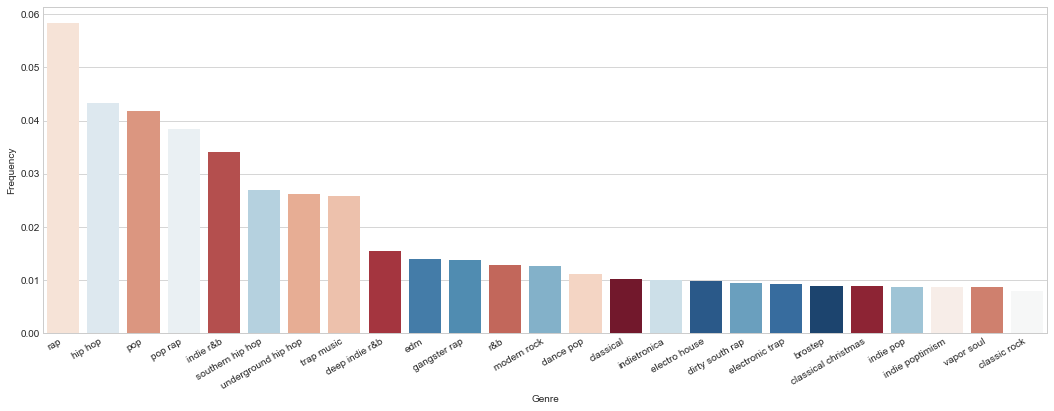

In [27]:
offset = 0
collective_genres = collective_genres.sort_values('freq', ascending=False)

plt.subplots(figsize=(18,6))
g = sns.barplot(x='genre', y='freq', 
                data=collective_genres[offset:offset+25], 
                hue='var1', palette='RdBu', dodge=False)
g.legend_.remove()
plt.xticks(rotation=30, horizontalalignment='right')
plt.xlabel('Genre')
plt.ylabel('Frequency');

What is the overall mood of my music collection like? It is skewed toward a sadder mood, and has a mean valence of 0.4, which isn't particularly happy.

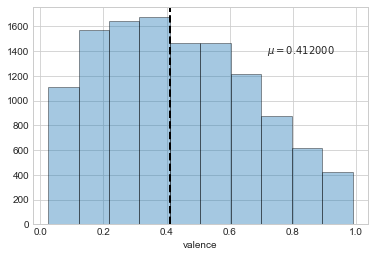

In [28]:
ax = sns.distplot(full_history.valence, bins=10, kde=False, hist_kws={"edgecolor": "k", "linewidth":1})
plt.axvline(full_history.valence.median(), color='k', linestyle='--', linewidth=2);
plt.text(0.8, 0.8, r'$\mu={0:2f}$'.format(full_history.valence.median()), 
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes);

Who are my most listened to artists?

In [29]:
collective_artists = [artists for artists in full_history.loc[full_history['artists'].notnull(), 'artists']]
    
collective_artists = np.array(list(itertools.chain(*collective_artists)))
unique_artists, artist_counts = np.unique(collective_artists, return_counts=True)

artist_df = pd.DataFrame({'id': unique_artists, 'listens': artist_counts})
artists = pd.merge(artist_df, artists, on='id')

def simplifyGenre(x):
    for genre in collective_genres['genre']:
        if genre in x:
            return genre
        
    return 'other'

artists['simple_genre'] = artists['genres'].apply(simplifyGenre)

Below is a visualization of my most listened to artists. They are counted if they are featured or produce a song as well. The color represents their top-level genre classification.

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


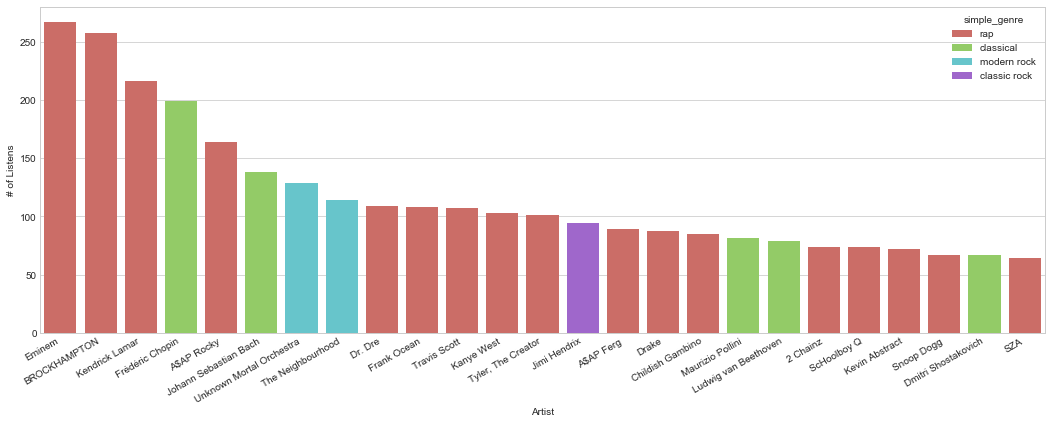

In [30]:
offset = 0
sort_artist_df = artists.sort_values('listens', ascending=False)

plt.subplots(figsize=(18,6))
g = sns.barplot(x='artist', y='listens', data=sort_artist_df[offset:offset+25], hue='simple_genre', dodge=False, palette='hls')
plt.xticks(rotation=30, horizontalalignment='right')
plt.xlabel('Artist');
plt.ylabel('# of Listens');
#plt.savefig('topartists.png')

How does my music collection look in terms of song length?

The mean song is 3:52 minutes, the median is 3:40 minutes, and 75% of my music is shorter than 4:19 minutes. My five longest songs include two European classical pieces, two Indian classical pieces, and SB-01, an experimental track by Unknown Mortal Orchestra.

In [31]:
print(pd.Series(full_history['duration']).describe())
full_history.sort_values('duration')[['name', 'duration']].tail(5)

count    12047.000000
mean         3.883627
std          1.395982
min          0.566450
25%          3.162992
50%          3.669283
75%          4.351750
max         41.074900
Name: duration, dtype: float64


,name,duration
10252,Raag Mishra Shirvranjani Taal Deepchandi,21.820150
2638,"Piano Concerto No. 1 in B-Flat Minor, Op. 23: ...",22.037783
7068,SB-01,22.143333
5536,"Tod und Verklärung Op.24, TrV 158",27.024000
9985,"Rag Bhimpalasi: Alap, Jod, Jhala",41.074900


## When do I listen to music?

It's unlikely I'm always listening to music, 24/7. So what does the time frame of my listening actually look like?

Above I mentioned that on average I listen to about 78 songs per day. Since I've started recording my listening, how have I deviated from that? The graph below shows the "rate" of my music listening, overlaid with a linear estimation of exactly 78 songs per day. Around late March was Finals week and the beginning of my Spring Break, hence the steep rise in music listening (less time in class, more time in the library/relaxing at home). Following that is a flatline of music listening, which corresponds to a vacation I took with my girlfriend. I was spending time exploring a new place and being present with her, instead of listening to music.

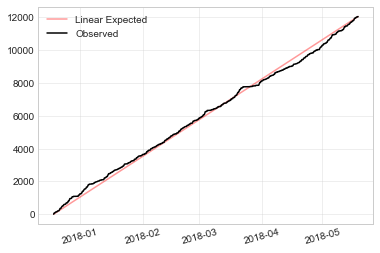

In [33]:
dates = full_history['timestamp'].sort_values().reset_index(drop=True)
plt.xticks(rotation=15)
plt.plot([min(full_history['timestamp']), max(full_history['timestamp'])], 
         [0, max(dates.index)], 
         'r-', alpha=0.4, label='Linear Expected')
plt.plot(dates.values, dates.index, c='k', label='Observed')
plt.legend()
plt.grid(alpha=0.4)

During the average week, when do I listen to music?

In [34]:
def makeWeekday(a):
    '''
    weekday
    '''
    return a.weekday()

In [35]:
full_history['weekday'] = full_history['timestamp'].apply(makeWeekday)

In [36]:
def makeDecimalHour(a):
    '''
    decimal hour
    '''
    return a.hour + (a.minute / 60.0)

In [37]:
full_history['hour_decimal'] = full_history['timestamp'].apply(makeDecimalHour)

In [38]:
def _averageDatetimeFrequency(df, hour_inc):
    hour_bins = np.arange(0, 24+hour_inc, hour_inc)
    hour_labels = np.arange(hour_inc, 24+hour_inc, hour_inc)

    df['time_bin'] = pd.cut(df['hour_decimal'], bins=hour_bins, labels=hour_labels)
    
    history_time_bivar = df.groupby(['weekday', 'time_bin'], axis=0)
    return history_time_bivar.size().unstack().fillna(0)

def plotAverageDatetimeFrequency(data, title='', fs=(12,5), hour_inc=0.5):
    plt.subplots(figsize=fs)
    plt.title('Average Listening Date-time Frequency{}'.format(title))
    g = sns.heatmap(_averageDatetimeFrequency(data, hour_inc), cmap="Blues", robust=True)
    plt.xlabel('Time Bin')
    plt.ylabel('Weekday')
    g.set(yticklabels=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']); # use ; to suppress output

The heatmap below attempts to answer the above question. Darker squares are hours on a specific day of the week in whih I've listened to a lot of music. Notice the lack of 3am-6am, where I have never listened to music. The light areas during the week around 2-5pm correspond with my practice schedule, a time in which music listening is impossible.

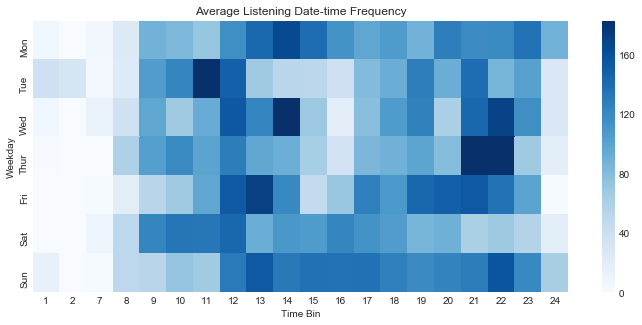

In [39]:
plotAverageDatetimeFrequency(full_history, hour_inc=1)

In [ ]:
inc = 1

hour_labels = np.arange(inc, 24+inc, inc)
day_bins = np.arange(0,7)

genres_matrix = []

w = []
for day in day_bins:
    d = []
    for hour in hour_labels:
        genres = full_history.loc[(full_history['weekday'] == day) & (full_history['time_bin'] == hour), 'genres']
        
        if list(genres):
            unique_genres, genres_counts = np.unique(list(itertools.chain(*genres.dropna())), return_counts=True)
            i, = np.where(genres_counts==genres_counts.max())
            i = i[0]
            d.append(str(unique_genres[i]))
        else:
            d.append('none')
    w.append(d)
    
d = pd.DataFrame(w)

In [ ]:
u = np.unique(d)
u = dict(zip(u, range(len(u))))
d = d.replace(u)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
im = plt.imshow(d, cmap='', aspect=3)

cb = fig.colorbar(im)
cb.set_ticks(list(u.values()))
cb.set_ticklabels(list(u.keys()))  # put text labels on them

# Major ticks
ax.set_xticks(np.arange(0, 24, 1));
ax.set_yticks(np.arange(0, 7, 1));

# Minor ticks
ax.set_xticks(np.arange(-.5, 23, 1), minor=True);
ax.set_yticks(np.arange(-.5, 6, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major', b=False)

ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

plt.xlabel('Hour of the Day')
plt.ylabel('Weekday');

Are there artists I prefer at a certain time of day? Let's limit our search to artists who follow these requirements:

 1. if we lay out all the hours of the day that I've listened to a song by that artist, we get a vector (or array) of hours (in decimal). We only consider artists that have at most 3 hours between the 25% quantile hour and the 75% quantile hour. This ensures artists are truly localized to a certain time of the day
 2. out of all artists, let's find the 90% quantile of listen counts. In this case it happens to be 9 listens. We only consider artists that have an equivalent amount of listens or more than this. This ensures I actually do listen to this artist. We don't want some artist with only 2 listens being included in our results.

In [40]:
MAX_SPREAD = 3.0
MIN_COUNT = np.percentile(artists['listens'], 90)
MAX_SPREAD, MIN_COUNT

(3.0, 9.0)

In [41]:
def is_compact(arr):
    prc25, prc75 = np.percentile(arr, [25, 75])
    return (prc75 - prc25) <= MAX_SPREAD

selected_artists = []

for artist in artists.itertuples():
    track_hours = []
        
    if artist.listens < MIN_COUNT: continue
        
    for track in full_history.itertuples():
        if artist.id in track.artists:
            track_hours.append(track.hour_decimal)
            
    if is_compact(track_hours):
        selected_artists.append([artist.artist, artist.id, np.median(track_hours)])

artists_dayhours = pd.DataFrame(selected_artists, columns=['artist', 'id', 'hour'])

Interestingly, we see a handul of artists are in fact localized to a certain time of the day for me. For example, we see some classic rock bands (The Kinks, The Who) localized to the morning and afternoon. I have a tendency to listen to classical music before bed, hence Gould, Vivaldi, and Debussy all 9pm and later artists.

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


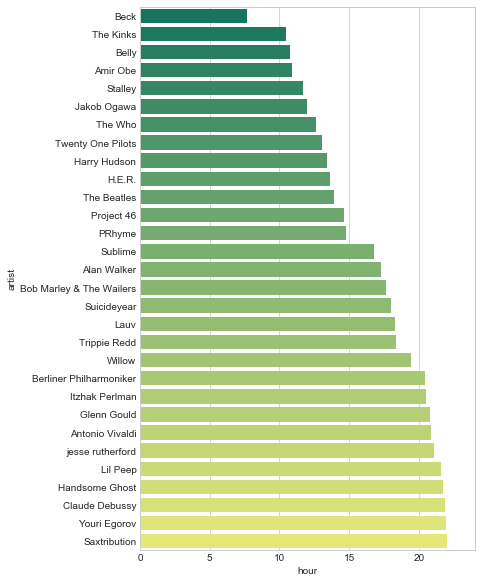

In [42]:
a = artists_dayhours.sort_values('hour')
plt.subplots(figsize=(6,10))
plt.xlim([0,24])
sns.barplot(a['hour'], a['artist'], orient='h', palette='summer')

When I listen to music, how much do I listen to? We create the idea of a listening *cluster*, which is a period of time in which I listened to consecutive music. In one cluster, I might listen to just a single song, or 20 songs back-to-back, or a few hours of music on end.

We examine this by creating clusters which depend on the time between one song at time $t_i$ and the next song at time $t_{i+1}$, and comparing this value to the duration of the song at $t_i$ plus some time extension. This extension allows little breaks in listening to be had (e.g. pausing in the middle of the song for a minute), but still allows it to continue the chain of songs.

$$C = \{t\in T \mid t_{i+1} - t_i < \epsilon \textrm{ and } t_i \leq t_{i+1}\}$$

where $T$ is the set of all song timestamps, and $t_i$ is the timestamp of some song such that the timestamp $t_{i+1}$ occurs next, $t_i \leq t_{i+1}$. $\Delta$ is equal to the duration of the song at time $t_i$ and $\epsilon$ is the cluster width extension variable ($\epsilon > 0$). Various cluster width extensions are shown in the graph below. A cluster $C$ is the set such that $\Delta + \epsilon$ is greater than the amount of time between the timestamps $t_{i+1}$ and $t_i$.

The results resemble a logarithmic graph, and are somewhat linear when log transformed. When the cluster width extension, $\epsilon$, is 5 minutes, the average cluster duration is about 36 minutes. This is interpreted as, if we consider a grouping of listening to occur when one song is played within five minutes of the end of the previous song, I will listen for about 36 minutes. After that, I'll take a break of at least five minutes.

In [43]:
full_history['timestamp_64'] = pd.DatetimeIndex(full_history['timestamp']).view('int64') // pd.Timedelta(1, unit='s')
T = full_history.copy()
T = T.sort_values('timestamp_64', ascending=True)
T = T.reset_index(drop=True)

t_i1 = np.array(T.loc[1:, 'timestamp_64'])
t_i = np.array(T.loc[:len(T)-2, 'timestamp_64'])
raw_deltas = t_i1 - t_i

T.drop(0, axis=0, inplace=True)
T.loc[:, 'duration'] *= 60
T.loc[:, 'delta'] = np.array(raw_deltas)
# duration is the song duration in seconds
# delta is the number of seconds from the ith to the (i+1)th record

In [44]:
cluster_means = []
MAXIMUM_GAPS = np.arange(0,20)

for MAXIMUM_GAP in MAXIMUM_GAPS:
    clusters = []
    current_cluster = 0
    for row in T.itertuples():
        
        current_cluster += row.duration
        
        if row.delta > (MAXIMUM_GAP * 60):
            clusters.append(current_cluster)
            current_cluster = 0
            
    clusters.append(current_cluster)
    clusters = pd.Series(clusters) / 60
    cluster_means.append(round(np.mean(clusters), 1))

We see that as we increase the gap of time between one song and the song after, the clusters get longer and longer until the increase in cluster duration becomes linear. As interpretation: if we cluster together all songs that are at most 5 minutes apart, the average cluster of music is 20.9 minutes. At a 15 minute extension, clusters become 56 minutes long on average.

3.8835749377386883


0      3.9
1      4.0
2      4.4
3      6.5
4     12.6
5     20.9
6     29.2
7     35.2
8     39.3
9     44.0
10    46.5
11    48.6
12    50.8
13    52.9
14    54.7
15    56.0
16    57.2
17    58.1
18    59.3
19    60.6
dtype: float64

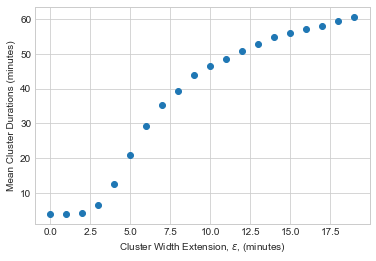

In [45]:
plt.xlabel('Cluster Width Extension, $\epsilon$, (minutes)')
plt.ylabel('Mean Cluster Durations (minutes)')
plt.scatter(x=MAXIMUM_GAPS, y=cluster_means)
print(np.mean(T.duration)/60)
pd.Series(cluster_means, index=MAXIMUM_GAPS)

What's the probability I'll play another song within 10 minutes of the last song?

In [46]:
mn = 1
mx = 100
ks = np.arange(mn, mx)
EXTENSION = 10 * 60

counts = []

# for each listening item, starting wiht the earliest
for row in T.itertuples():
    in_count = np.zeros(len(ks)+1)
    
    # iterate up to maximum lookahead
    for k in ks:
        i = row.Index
        
        # if the lookahead is within the range, is the item k+1 ahead of i greater than the maximum CWE?
        if i+k < len(T) and T.loc[i+k+1, 'delta'] > EXTENSION:
            
            # if it is, increment the kth value to indicate the lookahead ends there
            in_count[k] += 1
            break
                
    counts.append(in_count)
        
c = pd.DataFrame(counts, columns=np.arange(mn, mx+1))
c.drop(1, axis=0, inplace=True)
c = c.sum(axis=0) / c.sum().sum()

If I listen to one song, the probability of playing one more within 10 minutes is about 8%. 

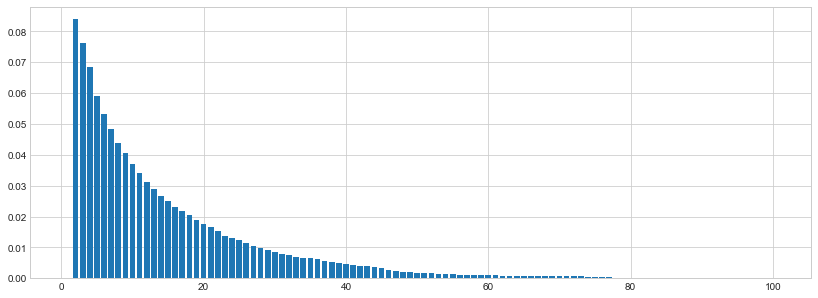

In [47]:
plt.subplots(figsize=(14,5))
plt.bar(c.index, c.values);

## What music do I *actually* like?

With thousands of songs in my music listening history, it should be obvious that I don't *love* all of them. If we wish to describe the songs I like, the dataset must be labeled with whether I like a particular song. In other words, we extract implicit feedback to classify songs as "Like" or "Dislike." Implicit feedback is easier to collect because it does not require individually labeling each sample. Here, we define this feedback as listening frequency. It is assumed that songs that are enjoyed are listened to more often than songs that are not enjoyed.

There are two flavors of frequency feedback: absolute and relative. Absolute frequency feedback (AFF) is the listening frequency within the know period of recording. Relative frequency feedback (RFF) is the listening frequency between the first and last listening event. AFF accounts for long-term listening habits. RFF accounts for songs that were enjoyed during one period in time (and may still be enjoyed).

In [ ]:
day_range = (full_history['timestamp'].max() - full_history['timestamp'].min()).days

In [ ]:
bins = pd.date_range(min(full_history['timestamp']) - pd.Timedelta(weeks=1),
                     max(full_history['timestamp']) + pd.Timedelta(weeks=1),
                     freq='W', normalize=True)
labels = list(range(1, len(bins)))
T = full_history.copy()
T['week'] = pd.cut(full_history['timestamp_64'],
                               bins=bins.astype(np.int64)//10**9,
                               labels=labels)
T['week'] = T['week'].astype(np.int)

In [ ]:
unique = get_unique().sort_values('timestamp_64')

In [ ]:
for row in unique['id']:
    
    weeks = T.loc[T['id'] == row, 'week']
    uweeks, counts = np.unique(weeks, return_counts=True)
    
    gain = np.log(sum(counts)/(np.median(weeks)/(len(uweeks)/len(bins))))
    
    unique.loc[unique['id'] == row, 'gain'] = gain

In [ ]:
s_gains = np.array(sorted(unique['gain']))
plt.plot(range(len(s_gains)), s_gains, linewidth=1.5, label='Weighted')
l = sorted(listens)
plt.plot(range(len(l)), l, label='Raw')
plt.legend()

In [ ]:
cols = ['acousticness', 'danceability', 'energy', 'explicit', 'mode', 'popularity', 'speechiness', 
        'tempo', 'valence', 'duration', 'log_loudness']

X_train, X_test, y_train, y_test = train_test_split(unique[cols], unique['gain'], test_size=0.4)
y_test, y_validate = y_test[:int(len(y_test)/2)], y_test[int(len(y_test)/2):]
X_test, X_validate = X_test[:int(len(X_test)/2)], X_test[int(len(X_test)/2):]

In [ ]:
from sklearn.linear_model import *
clf = LinearRegression()

clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

pd.Series(clf.predict(X_validate)).describe()

In [ ]:
unique_counts = []

last = full_history['timestamp'].max()

for i, row_outer in full_history.iterrows():
    matches = full_history.loc[full_history['id'] == row_outer['id'], 'timestamp']
    
    n = len(matches)
        
    ts = np.array(matches.sort_values())
    spread = int((ts.max() - ts.min()) / 8.64e13)
    spread = 1 if spread == 0 else spread
    
    rff = 1
    med = 0
    if n > 1:
        deltas = (ts[1:] - ts[:-1]) / 8.64e13
        med = int(np.median(deltas))
        rff = n / spread
    
    distance = last - matches.max()

    unique_counts.append([row_outer['id'], row_outer['name'], n, n / day_range, rff, distance.total_seconds()])
    

In [ ]:
unique = pd.DataFrame(unique_counts, columns=['id', 'name', 'n', 'aff', 'rff', 'distance']).drop_duplicates('id')

## Do I prefer to discover new music or stick with known songs?

Do I have any go-to songs? artists? A go-to song is a song...

Do I have any hidden favorite songs? artists?

How much of my collection is from artists from my list of top artists?

The top 1% of artists ($n=40$) make up 27% of songs in my history, the top 5% of artists ($n=201$) make up 52% of songs, the top 10% of artists ($n=403$) make up 66% of songs, and the top 25% of artists ($n=1007$) make up 82% of songs.

In [48]:
makeup = []
brackets = [0.01, 0.05, 0.1, 0.25]

for portion in brackets:
    
    top_portion = round(len(sort_artist_df) * portion)
    top_portion = sort_artist_df.iloc[:top_portion, 0]
    
    total_songs_in_portion = 0
    for row in full_history.itertuples():
        # for each track, look through the artists
        for artist in row.artists:
            # if at least one artist on the song is in the top portion, count it and skip the rest
            if artist in list(top_portion):
                total_songs_in_portion += 1
                break
            
    makeup.append([len(top_portion), total_songs_in_portion / len(full_history)])
    
makeup = np.array(makeup)

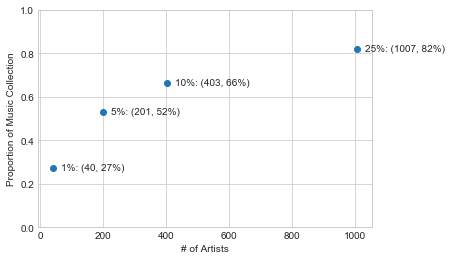

In [49]:
plt.scatter(x=makeup[:, 0], y=makeup[:, 1])

for i, elm in enumerate(makeup):
    plt.annotate('{}%: ({}, {}%)'.format(int(brackets[i]*100), int(elm[0]), int(elm[1]*100)), 
                 (elm[0], elm[1]), (elm[0]+25, elm[1]-0.01))

plt.xlabel('# of Artists')
plt.ylabel('Proportion of Music Collection')
plt.ylim([0,1]);

54.9% of artists I've listened to, I've only listened to once!

In [50]:
len(sort_artist_df[sort_artist_df['listens'] == 1])/len(sort_artist_df)

0.5485473056866154

# Is my music collection mainstream?

Compared to what most people are listening to, am I any different? (I'd like to think so, but we'll see)

In [ ]:
mainstream = pd.read_json('data/mainstream_music.json')

In [ ]:
mainstream['tempo'] = mainstream['tempo'].apply(round)
mainstream['tempo'] = mainstream['tempo'].apply(lambda x: x if x < 168 else x/2)

In [ ]:
#hist(mainstream['tempo'], [65,170])
sns.distplot(mainstream['tempo'])
full_history['tempo'].describe()

In [ ]:
mainstream['duration'] = mainstream['duration_ms'] / 1000 / 60
mainstream = mainstream.drop('duration_ms', axis=1)

In [ ]:
hist(mainstream['duration'], [2,8], 21)
print(mainstream['duration'].describe())